In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [3]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import traffic collisions data
- about and documentation https://data.torontopolice.on.ca/datasets/TorontoPS::traffic-collisions-asr-t-tbl-001/about

In [4]:
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson')

In [68]:
collision_df = pd.read_csv('../data/raw/Traffic_Collisions.csv')
collision_df.drop(columns=['x','y'], inplace=True)
collision_df

,occurrence_unique_id,occurrence_date,occurrence_month,occurrence_dayofweek,occurrence_year,occurrence_hour,hood_id,neighbourhood,fatalities,injury_collisions,ftr_collisions,pd_collisions,longitude,latitude
0,GO-20141283080,2014-01-04,January,Saturday,2014,22,58,Old East York (58),0,NO,YES,NO,-79.336333,43.697612
1,GO-20141384134,2014-01-21,January,Tuesday,2014,12,11,Eringate-Centennial-West Deane (11),0,NO,NO,YES,-79.561759,43.664797
2,GO-20141283152,2014-01-04,January,Saturday,2014,22,130,Milliken (130),0,NO,YES,NO,-79.280932,43.828194
3,GO-20141384194,2014-01-21,January,Tuesday,2014,12,27,York University Heights (27),0,YES,NO,NO,-79.471439,43.767827
4,GO-20141283293,2014-01-04,January,Saturday,2014,22,130,Milliken (130),0,NO,NO,YES,-79.282497,43.822062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526251,GO-202241692,2021-12-24,December,Friday,2021,1,21,Humber Summit (21),0,NO,NO,YES,-79.543408,43.770921
526252,GO-20228023273,2021-09-27,September,Monday,2021,17,NSA,NSA,0,NO,NO,YES,0.000000,0.000000
526253,GO-20228035384,2021-12-31,December,Friday,2021,16,36,Newtonbrook West (36),0,YES,NO,NO,-79.420043,43.798000
526254,GO-20228035412,2021-12-30,December,Thursday,2021,14,1,West Humber-Clairville (1),0,NO,NO,YES,-79.601404,43.730470


In [69]:
collision_df.occurrence_date.max()

'2021-12-31'

In [70]:
collision_df.shape

(526256, 14)

## No missing data

In [71]:
print("Columns with missing data")
collision_df.isna().sum()[collision_df.isna().sum() != 0]

Columns with missing data


Series([], dtype: int64)

## Split hood_id from neighbourhood

In [72]:
collision_df['neighbourhood'] = collision_df['neighbourhood'].str.split('(', 1, expand=True)[0]

In [73]:
# check that every NSA in hood_id is NSA in neighbourhood
# should only show "NSA" as the only unique entry
collision_df[collision_df['hood_id'] == "NSA"]['neighbourhood'].unique()

array(['NSA'], dtype=object)

In [74]:
# should only show "NSA" as the only unique entry
collision_df[collision_df['neighbourhood'] == "NSA"]['hood_id'].unique()

array(['NSA', '531'], dtype=object)

In [97]:
# fix the neighbourhood for hood_id = 531
collision_df.loc[(collision_df.hood_id == '531') & (collision_df.neighbourhood == 'NSA'), "hood_id"] = "NSA"

In [79]:
mci_select = pd.read_csv('../data/processed/mci_select.csv')

C:\Users\willi\AppData\Local\Temp\ipykernel_13516\163600350.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mci_select = pd.read_csv('../data/processed/mci_select.csv')


In [80]:
# keep the format consistent with major crime indicators
pd.concat([collision_df.iloc[0,:], mci_select.iloc[0,:]], axis=1)

,0,0
occurrence_unique_id,GO-20141283080,GO-2015194909
occurrence_date,2014-01-04,2015-02-02
occurrence_month,January,February
occurrence_dayofweek,Saturday,Monday
occurrence_year,2014,2015
occurrence_hour,22,NaN
hood_id,58,1
neighbourhood,Old East York,West Humber-Clairville
fatalities,0,NaN
injury_collisions,NO,NaN


In [81]:
collision_df['occurrence_date'] = pd.to_datetime(collision_df['occurrence_date'])

In [82]:
collision_df['occurrence_day'] = collision_df['occurrence_date'].dt.day.astype(int)
collision_df['occurrence_dayofyear'] = collision_df['occurrence_date'].dt.dayofyear.astype(int)

In [83]:
# now columns are similar to mci_select
pd.concat([collision_df.iloc[0,:], mci_select.iloc[0,:]], axis=1)

,0,0
occurrence_unique_id,GO-20141283080,GO-2015194909
occurrence_date,2014-01-04 00:00:00,2015-02-02
occurrence_month,January,February
occurrence_dayofweek,Saturday,Monday
occurrence_year,2014,2015
occurrence_hour,22,NaN
hood_id,58,1
neighbourhood,Old East York,West Humber-Clairville
fatalities,0,NaN
injury_collisions,NO,NaN


## Checking for inconsistencies

### inconsistency in hour of day

In [84]:
# is the year, month, day etc. consistent with the date column?
print(sum(collision_df.occurrence_date.dt.year != collision_df.occurrence_year))
print(sum(collision_df.occurrence_date.dt.strftime("%B") != collision_df.occurrence_month))
print(sum(collision_df.occurrence_date.dt.day.astype(float) != collision_df.occurrence_day))
print(sum(collision_df.occurrence_date.dt.dayofyear.astype(float) != collision_df.occurrence_dayofyear))
print(sum(collision_df.occurrence_date.dt.strftime("%A") != collision_df.occurrence_dayofweek))
print(sum(collision_df.occurrence_date.dt.hour != collision_df.occurrence_hour))

0
0
0
0
0
520157


In [85]:
# occurencehour looks incorrect
collision_df.loc[collision_df.occurrence_date.dt.hour != collision_df.occurrence_hour, ['occurrence_date', 'occurrence_hour']]

,occurrence_date,occurrence_hour
0,2014-01-04,22
1,2014-01-21,12
2,2014-01-04,22
3,2014-01-21,12
4,2014-01-04,22
...,...,...
526251,2021-12-24,1
526252,2021-09-27,17
526253,2021-12-31,16
526254,2021-12-30,14


In [86]:
# this does not make sense
collision_df.occurrence_date.dt.hour.describe()

count    526256.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: occurrence_date, dtype: float64

In [87]:
# this makes more sense that traffic collisions happen throughout the day
collision_df.occurrence_hour.describe()

count    526256.000000
mean         13.481262
std           4.926225
min           0.000000
25%          10.000000
50%          14.000000
75%          17.000000
max          23.000000
Name: occurrence_hour, dtype: float64

In [88]:
print("before fixing:", collision_df['occurrence_date'][0])
print("after fixing:", collision_df['occurrence_date'][0].replace(hour=int(collision_df['occurrence_hour'][0])))

before fixing: 2014-01-04 00:00:00
after fixing: 2014-01-04 22:00:00


In [89]:
dates = []
for date, hour in zip(collision_df.occurrence_date, collision_df.occurrence_hour):
    dates.append(date.replace(hour=int(hour)))

In [90]:
collision_df['occurrence_date'] = dates

### inconsistency in hood_ID and neighbourhood

In [98]:
# check if hood_id and neighbourhood are 1-to-1
# number of unique values in hood_id and neighbourhood should be the same
print(len(collision_df.hood_id.unique()), len(collision_df.neighbourhood.unique()))

141 141


In [99]:
check_duplicate = collision_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')

In [100]:
# duplicates in hood_id since some record are of int type, while some are strings
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')

,hood_id,neighbourhood,counts


In [101]:
# duplicate neighbourhood values due to white space
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')[:2].values

array([], shape=(0, 3), dtype=object)

In [102]:
collision_df['neighbourhood'] = collision_df['neighbourhood'].str.strip()

In [103]:
# no more duplicates due to white space but not have 2 due to format issues
check_duplicate = collision_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

,hood_id,neighbourhood,counts


In [104]:
# fix duplicate neighbourhood
# collision_df.loc[(collision_df.hood_id == '117') & (collision_df.neighbourhood == 'LAmoreaux'), 'neighbourhood'] = "L'Amoreaux"
# collision_df.loc[(collision_df.hood_id == '118') & (collision_df.neighbourhood == 'Tam OShanter-Sullivan'), 'neighbourhood'] = "Tam O'Shanter-Sullivan"

In [105]:
# no more duplicates
# check_duplicate = collision_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')
# check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

In [106]:
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')

,hood_id,neighbourhood,counts


### inconsistency vs neighbourhood boundary

In [107]:
merge_df = pd.merge(neighbourhoods[['neighbourhood', 'hood_id']], collision_df[['hood_id', 'neighbourhood']], on=['hood_id'], how='outer', suffixes=('_neighbourhood', '_collision'))
merge_df[merge_df['neighbourhood_neighbourhood'] != merge_df['neighbourhood_collision']].drop_duplicates(subset=['neighbourhood_neighbourhood'])

,neighbourhood_neighbourhood,hood_id,neighbourhood_collision
411660,L'Amoreaux,117,LAmoreaux
453159,Tam O'Shanter-Sullivan,118,Tam OShanter-Sullivan
2662767,O'Connor-Parkview,54,OConnor-Parkview
4041936,NaN,NSA,NSA


In [108]:
collision_df.loc[(collision_df.hood_id == '118') & (collision_df.neighbourhood == 'Tam OShanter-Sullivan'), 'neighbourhood'] = "Tam O'Shanter-Sullivan"
collision_df.loc[(collision_df.hood_id == '54') & (collision_df.neighbourhood == 'OConnor-Parkview'), 'neighbourhood'] = "O'Connor-Parkview"
collision_df.loc[(collision_df.hood_id == '117') & (collision_df.neighbourhood == 'LAmoreaux'), 'neighbourhood'] = "L'Amoreaux"

In [109]:
# now neighbourhoods are consistent
merge_df = pd.merge(neighbourhoods[['neighbourhood', 'hood_id']], collision_df[['hood_id', 'neighbourhood']], on=['hood_id'])
merge_df[merge_df['neighbourhood_x'] != merge_df['neighbourhood_y']].drop_duplicates(subset=['neighbourhood_x'])

,neighbourhood_x,hood_id,neighbourhood_y


## Fixing data types

In [113]:
collision_df.injury_collisions.unique()

array(['NO', 'YES'], dtype=object)

In [114]:
mapping = {'YES': 1, 'NO': 0}
collision_df.replace({'injury_collisions': mapping,
                      'ftr_collisions': mapping,
                      'pd_collisions': mapping}, inplace=True)

## Impute missing long and lat

In [115]:
collision_df.loc[(collision_df['longitude'] == 0) & (collision_df['latitude'] == 0), ["neighbourhood"]].value_counts()

neighbourhood               
NSA                             73511
Wexford/Maryvale                   74
West Hill                          32
Kennedy Park                       17
Yorkdale-Glen Park                 14
Hillcrest Village                  13
L'Amoreaux                         12
Glenfield-Jane Heights             10
Clairlea-Birchmount                 9
Bendale                             7
York University Heights             7
Islington-City Centre West          6
Agincourt South-Malvern West        6
Black Creek                         5
Highland Creek                      5
Bay Street Corridor                 3
West Humber-Clairville              3
Bayview Woods-Steeles               3
Pelmo Park-Humberlea                2
Bathurst Manor                      2
Church-Yonge Corridor               2
Westminster-Branson                 2
High Park North                     1
Woburn                              1
St.Andrew-Windfields                1
Scarborough Village  

In [116]:
# We can only estimate the location for those crimes with a neighbourhood associated to them 
# Drow rows without information about location and associated neighbourhood
collision_df = collision_df[~((collision_df['longitude'] == 0) & (collision_df['latitude'] == 0) & (collision_df['neighbourhood'] == "NSA"))].reset_index(drop=True)

In [117]:
missing_location = collision_df.loc[(collision_df['longitude'] == 0) & (collision_df['latitude'] == 0)].index
collision_df.loc[missing_location]

,occurrence_unique_id,occurrence_date,occurrence_month,occurrence_dayofweek,occurrence_year,occurrence_hour,hood_id,neighbourhood,fatalities,injury_collisions,ftr_collisions,pd_collisions,longitude,latitude,occurrence_day,occurrence_dayofyear
1944,GO-20141591056,2014-02-24 17:00:00,February,Monday,2014,17,40,St.Andrew-Windfields,0,0,1,0,0.0,0.0,24,55
11016,GO-20143120578,2014-10-17 09:00:00,October,Friday,2014,9,25,Glenfield-Jane Heights,0,0,0,1,0.0,0.0,17,290
173570,GO-20168053844,2016-11-30 18:00:00,November,Wednesday,2016,18,48,Hillcrest Village,0,0,0,1,0.0,0.0,30,335
174474,GO-20168055402,2016-12-10 12:00:00,December,Saturday,2016,12,119,Wexford/Maryvale,0,0,0,1,0.0,0.0,10,345
175537,GO-20168056919,2016-12-17 09:00:00,December,Saturday,2016,9,27,York University Heights,0,0,0,1,0.0,0.0,17,352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448343,GO-20218030414,2021-11-22 12:00:00,November,Monday,2021,12,31,Yorkdale-Glen Park,0,0,0,1,0.0,0.0,22,326
449438,GO-20218032244,2021-12-04 01:00:00,December,Saturday,2021,1,136,West Hill,0,0,0,1,0.0,0.0,4,338
449792,GO-20218032505,2021-12-07 13:00:00,December,Tuesday,2021,13,124,Kennedy Park,0,0,0,1,0.0,0.0,7,341
451066,GO-20218034960,2021-12-24 19:00:00,December,Friday,2021,19,14,Islington-City Centre West,0,0,0,1,0.0,0.0,24,358


In [118]:
missing_count = collision_df.loc[missing_location]['hood_id'].value_counts()
missing_count = missing_count.reset_index(drop=False).rename(columns={'index':'hood_id', 'hood_id':'count'})
missing_count

,hood_id,count
0,119,74
1,136,32
2,124,17
3,31,14
4,48,13
5,117,12
6,25,10
7,120,9
8,127,7
9,27,7


### Generate random points within neighbourhood

In [119]:
# randomly generate points within a defined neighbourhood
# https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
def generate_random(number, hood_id):
    selected_neighbourhood = neighbourhoods.loc[neighbourhoods['hood_id'] == str(hood_id)]
    polygon = selected_neighbourhood['geometry']
    points_x = []
    points_y = []
    count = 0
    try: 
        minx, miny, maxx, maxy = polygon.unique().bounds.flatten().tolist()
    except ValueError:
        print(selected_neighbourhood)
        print(f"No geometry for {hood_id}")
    while len(points_x) < number:
        pnt = shapely.geometry.Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt).values[0]:
            points_x.append(pnt.x)
            points_y.append(pnt.y)
        count += 1
    print(f"{count} points generated but only include the {len(points_x)} points within the neighbourhood")
    return pd.Series([points_x, points_y])

In [120]:
np.random.seed(123)
missing_count[['longitude', 'latitude']] = missing_count.apply(lambda x: generate_random(x['count'],x['hood_id']), axis=1)

103 points generated but only include the 74 points within the neighbourhood
60 points generated but only include the 32 points within the neighbourhood
20 points generated but only include the 17 points within the neighbourhood
18 points generated but only include the 14 points within the neighbourhood
29 points generated but only include the 13 points within the neighbourhood
28 points generated but only include the 12 points within the neighbourhood
14 points generated but only include the 10 points within the neighbourhood
11 points generated but only include the 9 points within the neighbourhood
16 points generated but only include the 7 points within the neighbourhood
16 points generated but only include the 7 points within the neighbourhood
11 points generated but only include the 6 points within the neighbourhood
12 points generated but only include the 6 points within the neighbourhood
8 points generated but only include the 5 points within the neighbourhood
10 points generate

In [121]:
# random locations generated for each neighbourhood with missing long and lat values
missing_count['len'] = missing_count['longitude'].apply(lambda x: len(x))
missing_count

,hood_id,count,longitude,latitude,len
0,119,74,"[-79.29057129960066, -79.31026462964951, -79.2...","[43.738453134139256, 43.751184896547585, 43.74...",74
1,136,32,"[-79.19791233972605, -79.15727315472547, -79.1...","[43.77300486915507, 43.76805243434983, 43.7754...",32
2,124,17,"[-79.25484157313207, -79.25699533833685, -79.2...","[43.73453891517708, 43.73245929086633, 43.7220...",17
3,31,14,"[-79.45350755814657, -79.45407743556785, -79.4...","[43.709857396545246, 43.72077910324961, 43.722...",14
4,48,13,"[-79.34615358052457, -79.33743857470185, -79.3...","[43.80241755405544, 43.80584722292745, 43.8057...",13
5,117,12,"[-79.3135712360792, -79.31002412651857, -79.32...","[43.78831390959985, 43.80516994333411, 43.7965...",12
6,25,10,"[-79.5161056326684, -79.50812587744433, -79.52...","[43.74578369242627, 43.74381310668748, 43.7415...",10
7,120,9,"[-79.28522167002957, -79.27619541870703, -79.2...","[43.72306126712974, 43.72525121908378, 43.7018...",9
8,127,7,"[-79.25832449534668, -79.25865588038218, -79.2...","[43.75428384344314, 43.776637793545014, 43.751...",7
9,27,7,"[-79.48036573643802, -79.49412278396144, -79.4...","[43.774193317409065, 43.770537230085665, 43.75...",7


In [122]:
# impute the missing long and lat values
for i in missing_count["hood_id"].unique():    
    index = (collision_df['hood_id'] == str(i)) & ((collision_df['longitude'] == 0) | (collision_df['latitude'] == 0))
    collision_df.loc[index, ['longitude', 'latitude']] = pd.DataFrame([np.where(collision_df.loc[index, 'longitude'] == 0, 
                                                                      missing_count[missing_count['hood_id'] == str(i)]['longitude'].iloc[0],
                                                                      collision_df.loc[index, 'longitude']),
                                                             np.where(collision_df.loc[index, 'latitude'] == 0, 
                                                                      missing_count[missing_count['hood_id'] == str(i)]['latitude'].iloc[0],
                                                                      collision_df.loc[index, 'latitude'])]).T.values

In [123]:
# check missing long and lat values are now imputed
collision_df.loc[missing_location]

,occurrence_unique_id,occurrence_date,occurrence_month,occurrence_dayofweek,occurrence_year,occurrence_hour,hood_id,neighbourhood,fatalities,injury_collisions,ftr_collisions,pd_collisions,longitude,latitude,occurrence_day,occurrence_dayofyear
1944,GO-20141591056,2014-02-24 17:00:00,February,Monday,2014,17,40,St.Andrew-Windfields,0,0,1,0,-79.348917,43.756067,24,55
11016,GO-20143120578,2014-10-17 09:00:00,October,Friday,2014,9,25,Glenfield-Jane Heights,0,0,0,1,-79.516106,43.745784,17,290
173570,GO-20168053844,2016-11-30 18:00:00,November,Wednesday,2016,18,48,Hillcrest Village,0,0,0,1,-79.346154,43.802418,30,335
174474,GO-20168055402,2016-12-10 12:00:00,December,Saturday,2016,12,119,Wexford/Maryvale,0,0,0,1,-79.290571,43.738453,10,345
175537,GO-20168056919,2016-12-17 09:00:00,December,Saturday,2016,9,27,York University Heights,0,0,0,1,-79.480366,43.774193,17,352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448343,GO-20218030414,2021-11-22 12:00:00,November,Monday,2021,12,31,Yorkdale-Glen Park,0,0,0,1,-79.457028,43.708184,22,326
449438,GO-20218032244,2021-12-04 01:00:00,December,Saturday,2021,1,136,West Hill,0,0,0,1,-79.200891,43.764992,4,338
449792,GO-20218032505,2021-12-07 13:00:00,December,Tuesday,2021,13,124,Kennedy Park,0,0,0,1,-79.266667,43.730877,7,341
451066,GO-20218034960,2021-12-24 19:00:00,December,Friday,2021,19,14,Islington-City Centre West,0,0,0,1,-79.550220,43.625224,24,358


### Add geometry points

In [124]:
collision_df['geometry'] = collision_df.apply(lambda x: shapely.geometry.Point(x['longitude'], x['latitude']), axis=1)

c:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [125]:
collision_point = gpd.GeoDataFrame(collision_df, crs='epsg:' + str(epsg_3d), geometry='geometry')

<AxesSubplot:>

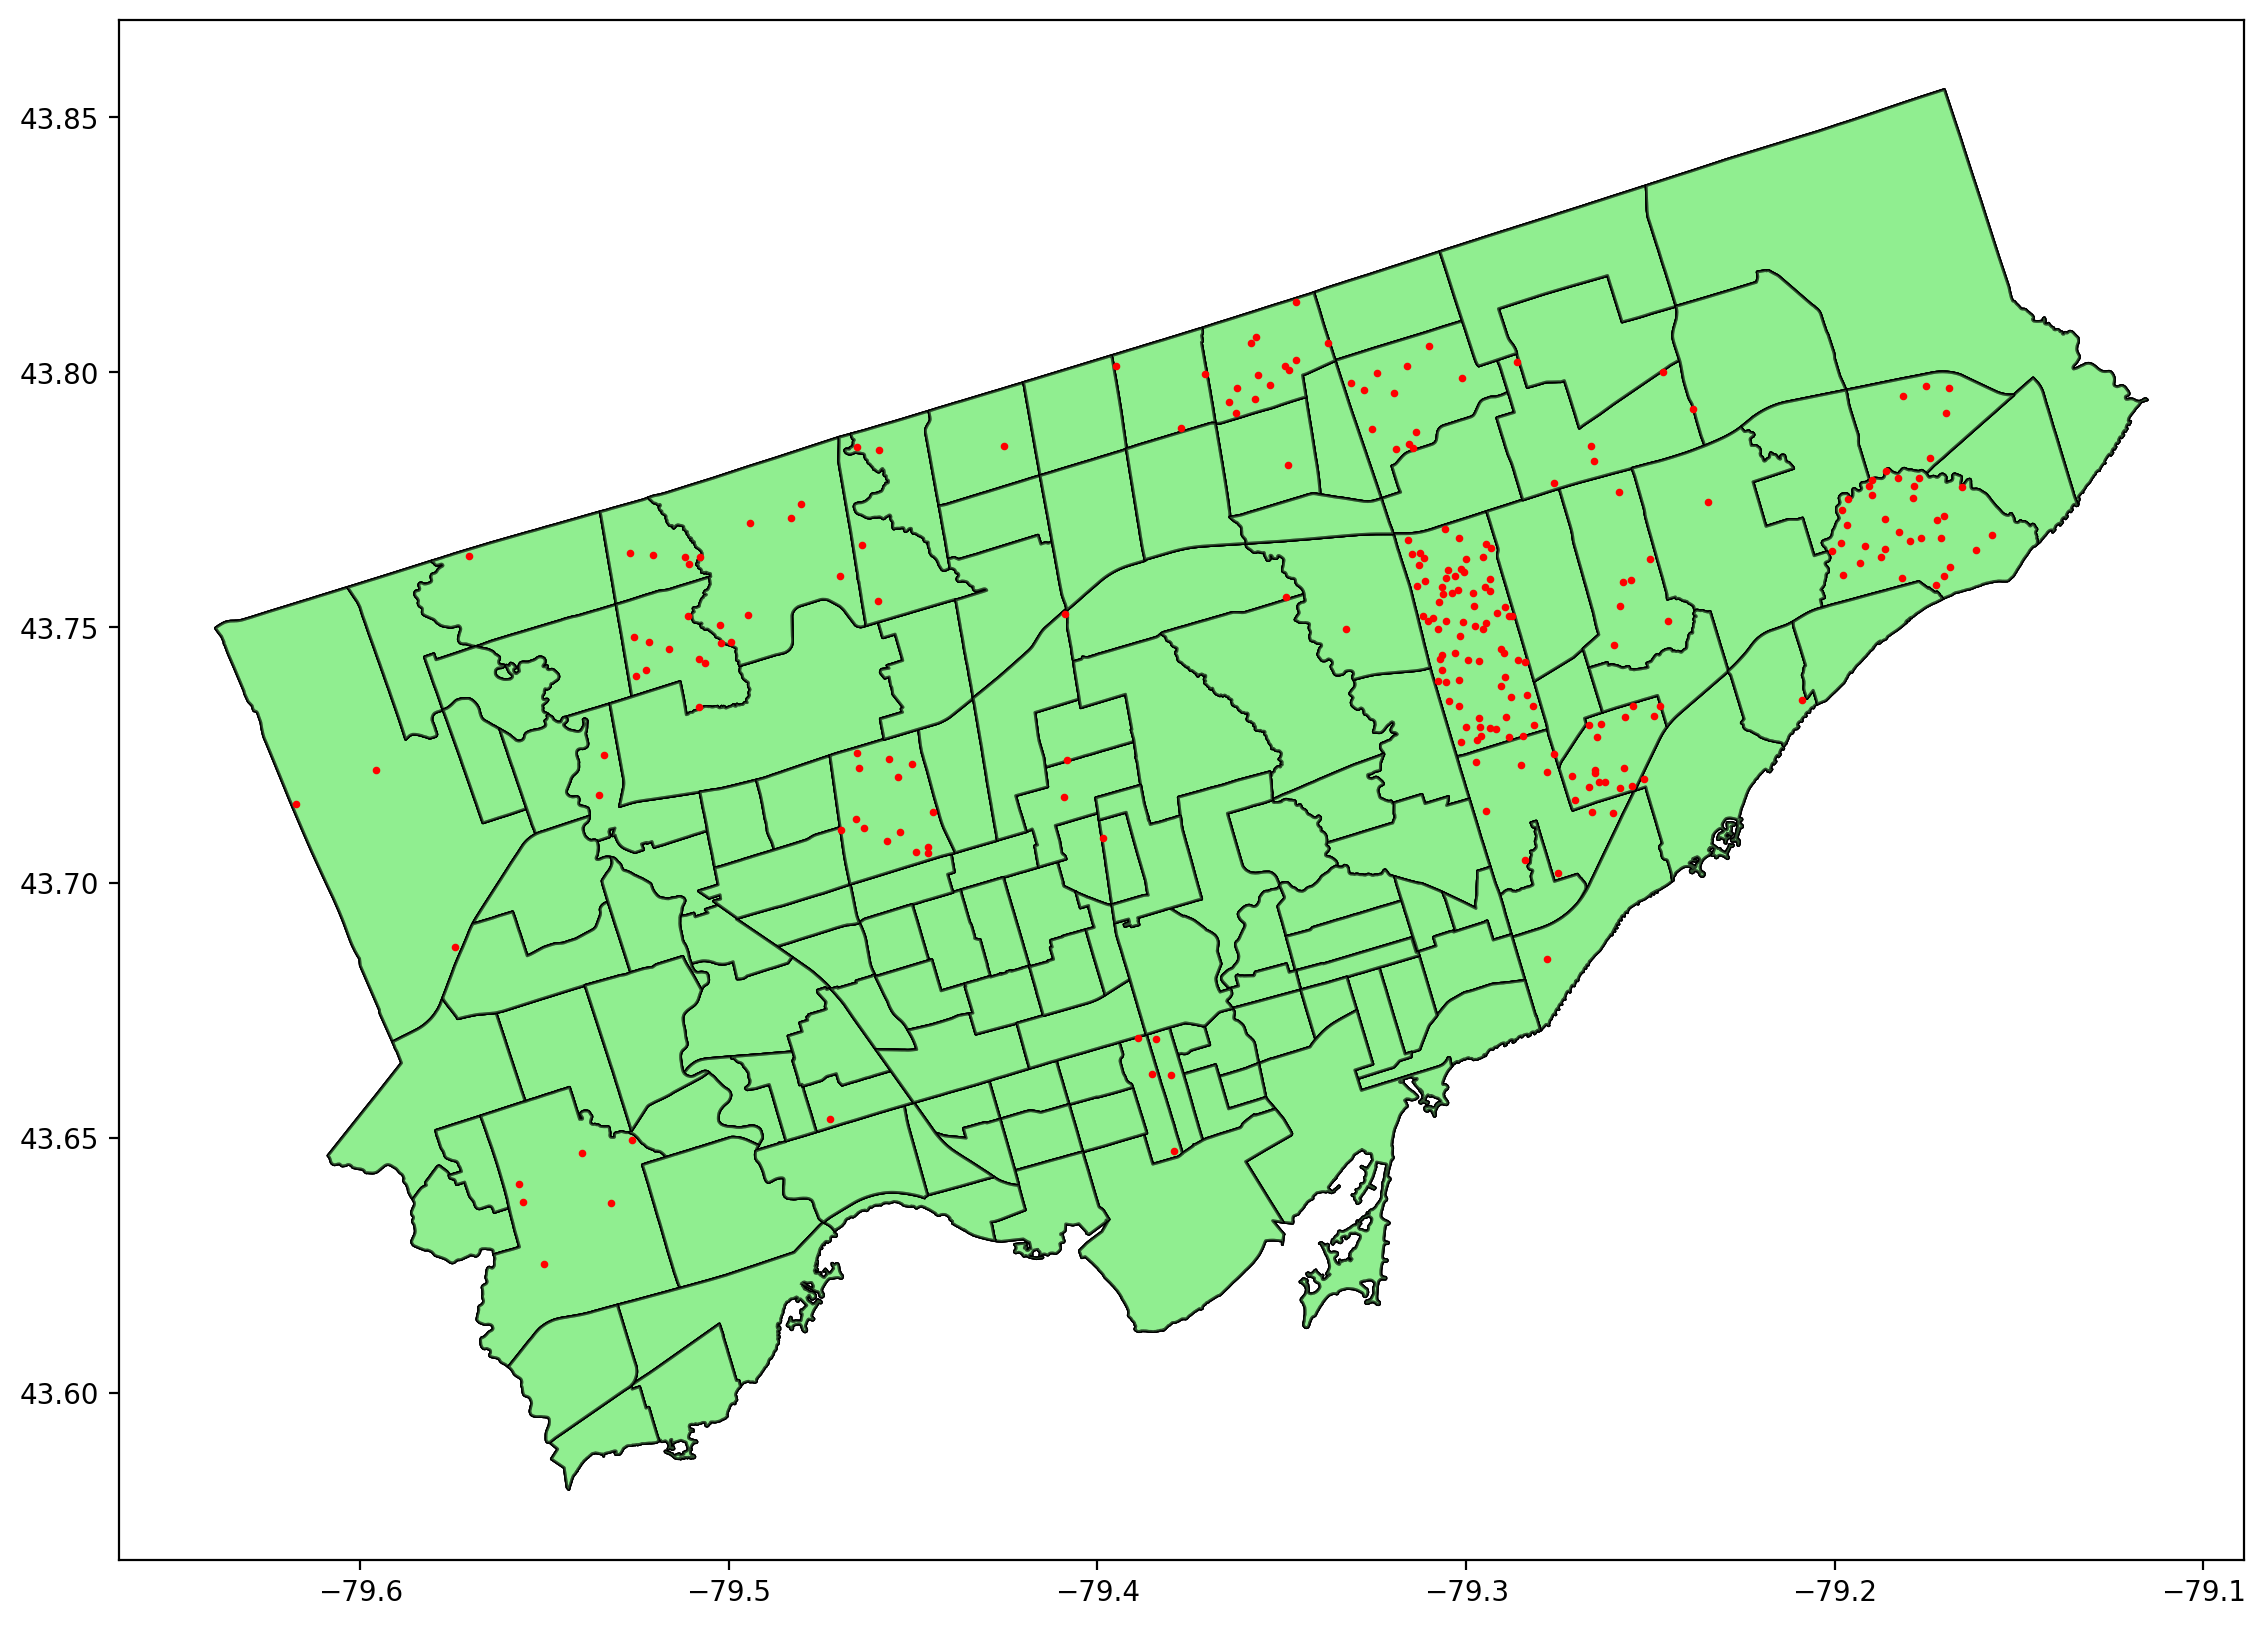

In [126]:
# show that random points generated to impute missing location are within the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point.loc[missing_location].plot(ax=ax, color = 'red', markersize = 3)

## NSA is not really 'Not Specified'

<AxesSubplot:>

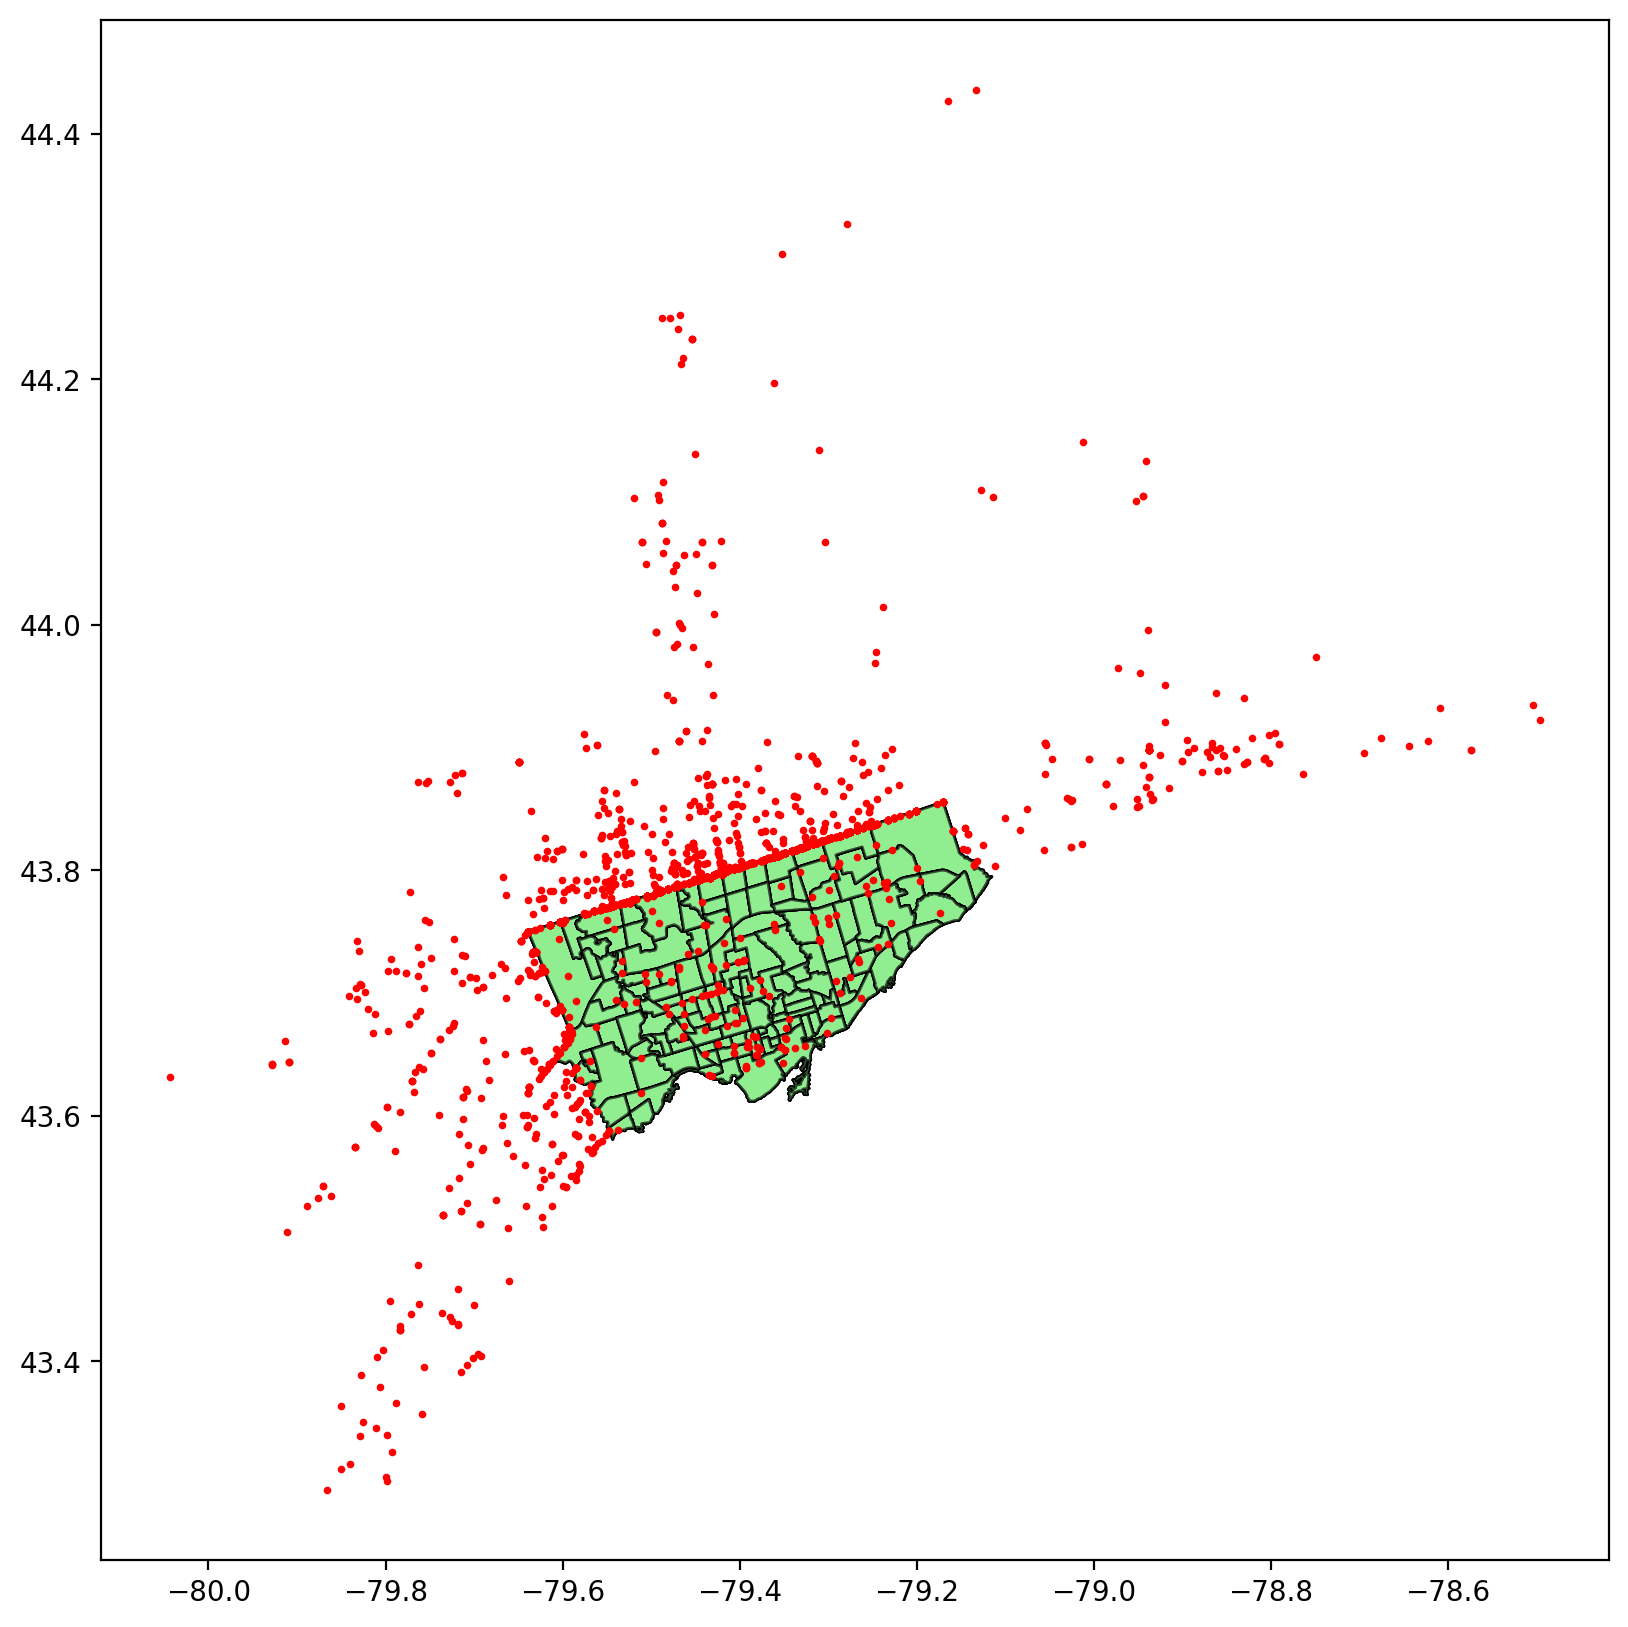

In [127]:
# some locations marked as NSA are actually within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [128]:
# get the points contained within the neighbourhood
NSA_within_neighbourhood = gpd.sjoin(collision_point[collision_point['neighbourhood'] == 'NSA'], 
                                    neighbourhoods, 
                                    op='intersects')
collision_point.loc[NSA_within_neighbourhood.index, ['hood_id', 'neighbourhood']] = NSA_within_neighbourhood[['hood_id_right', 'neighbourhood_right']].values

c:\Users\willi\miniconda3\envs\police\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

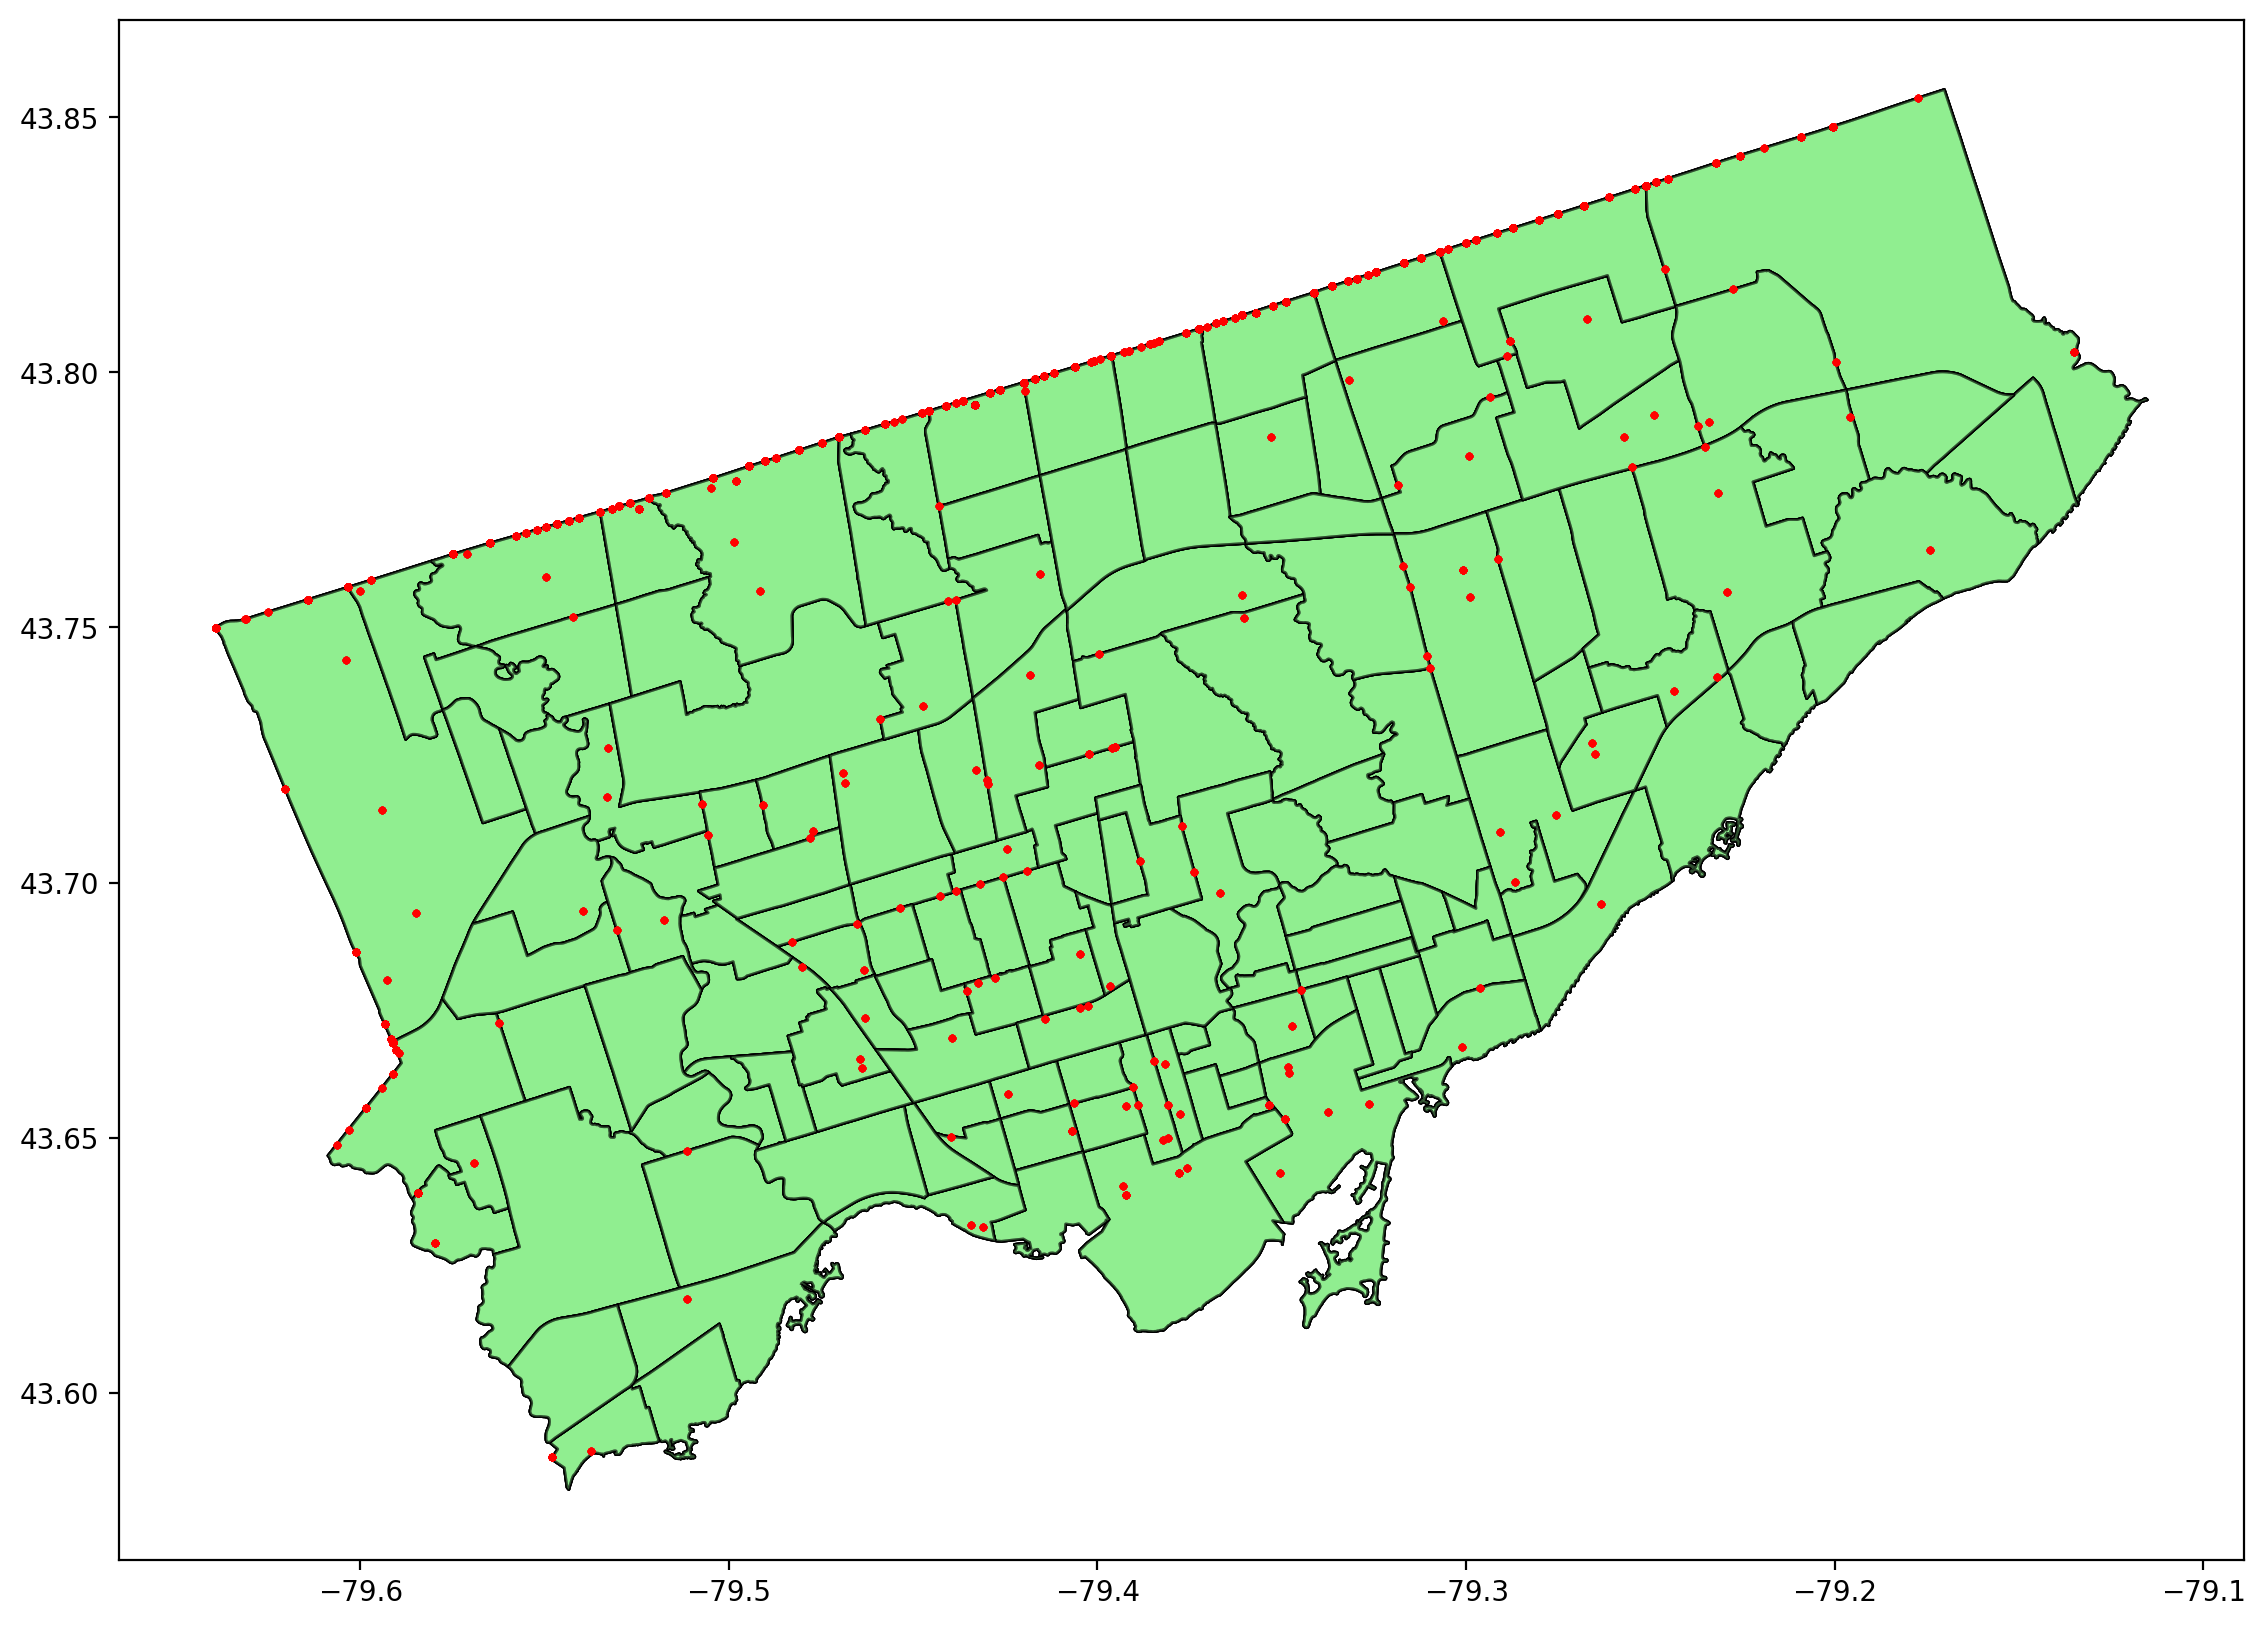

In [129]:
# check that we have correctly isolated only the locations within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point.loc[NSA_within_neighbourhood.index].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

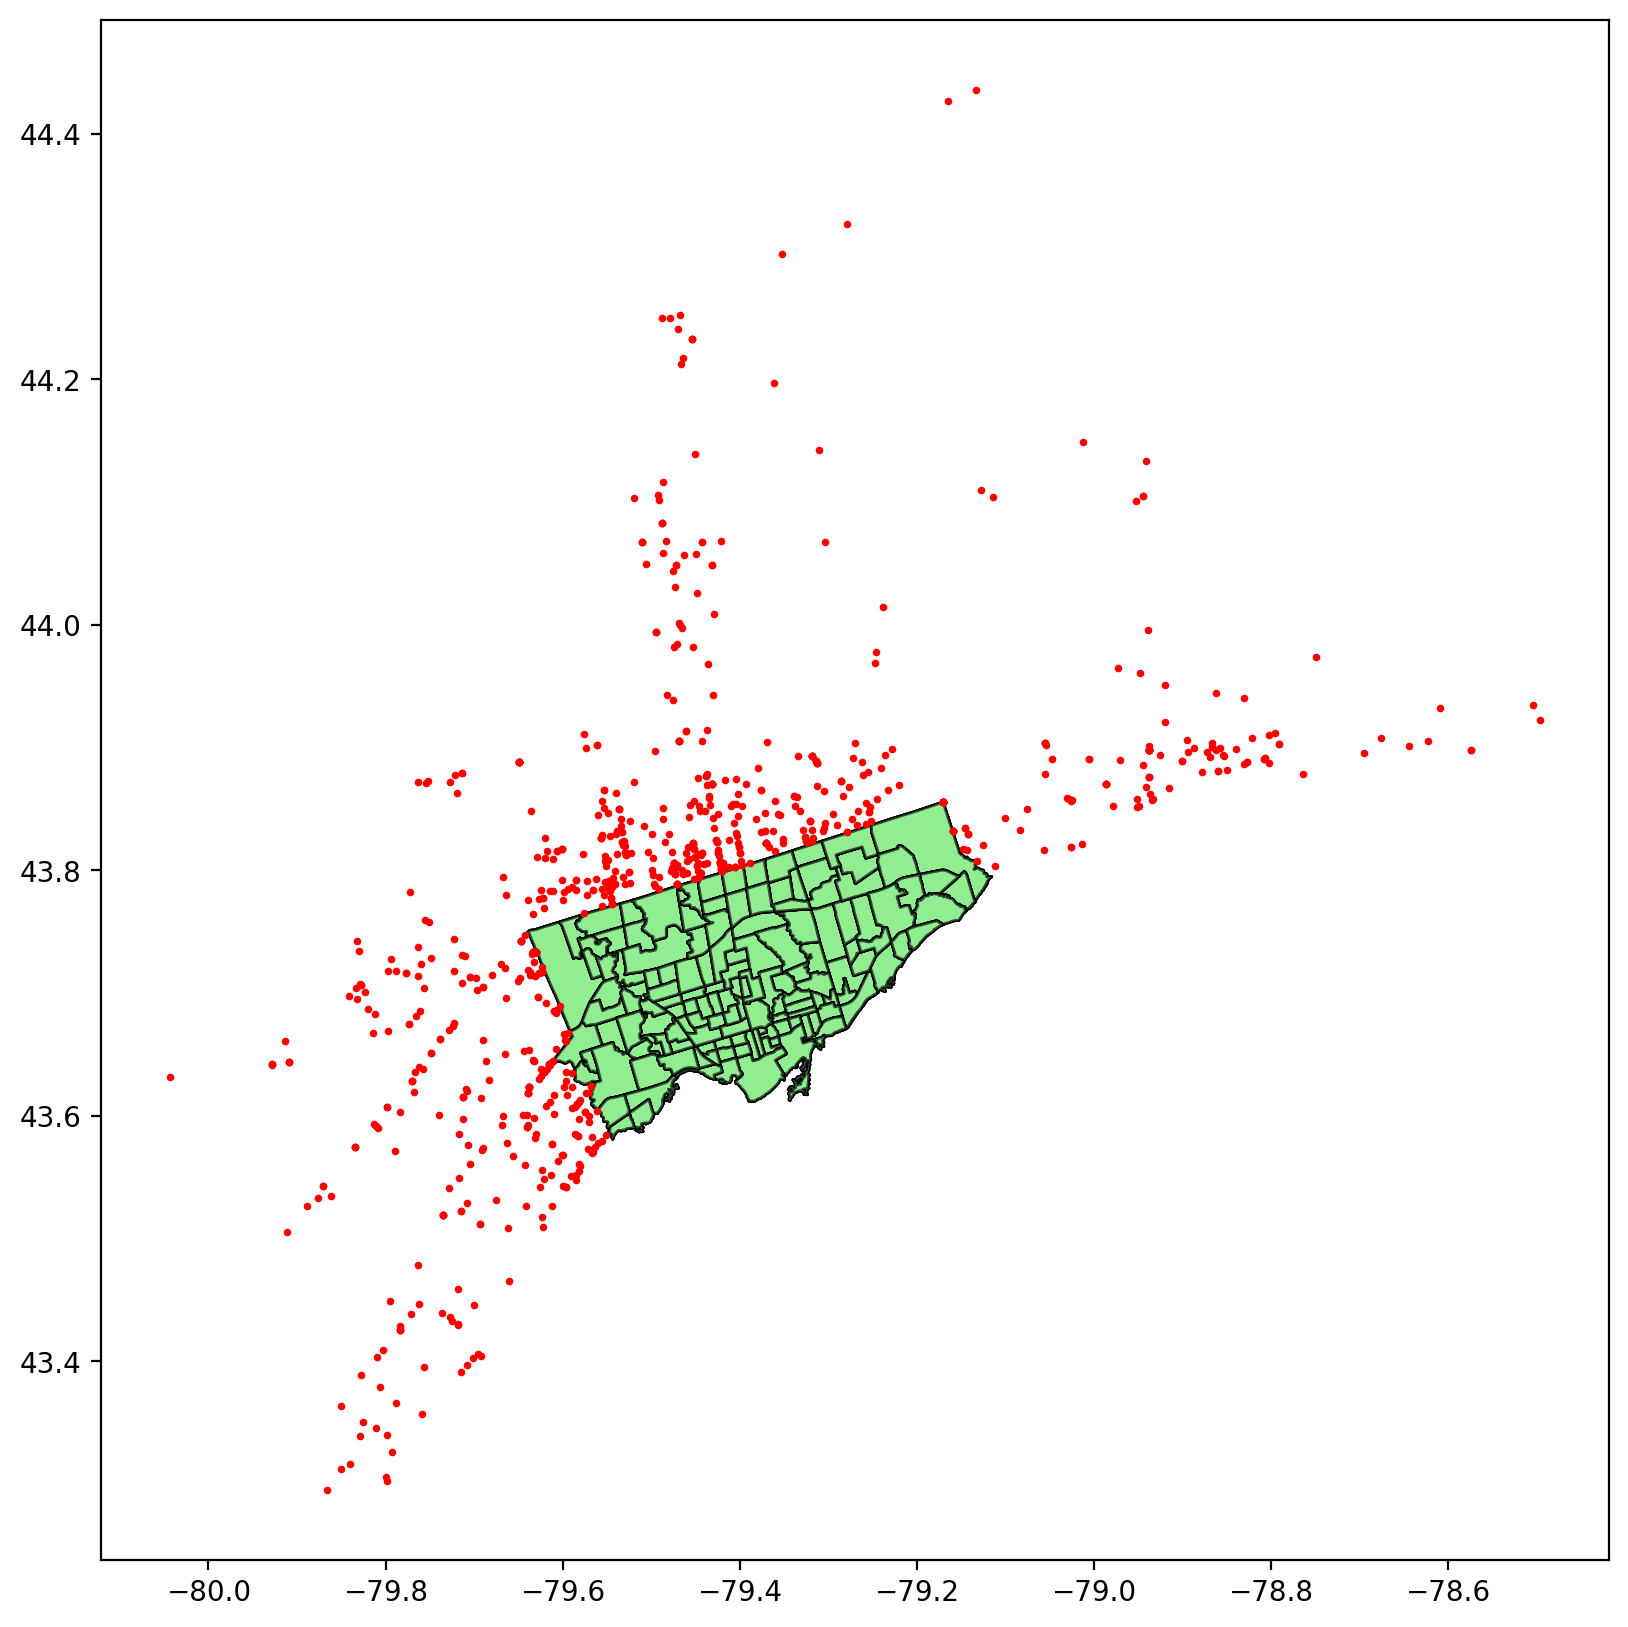

In [130]:
# check that now all the locations with neighbourhood as NSA are outside any out the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

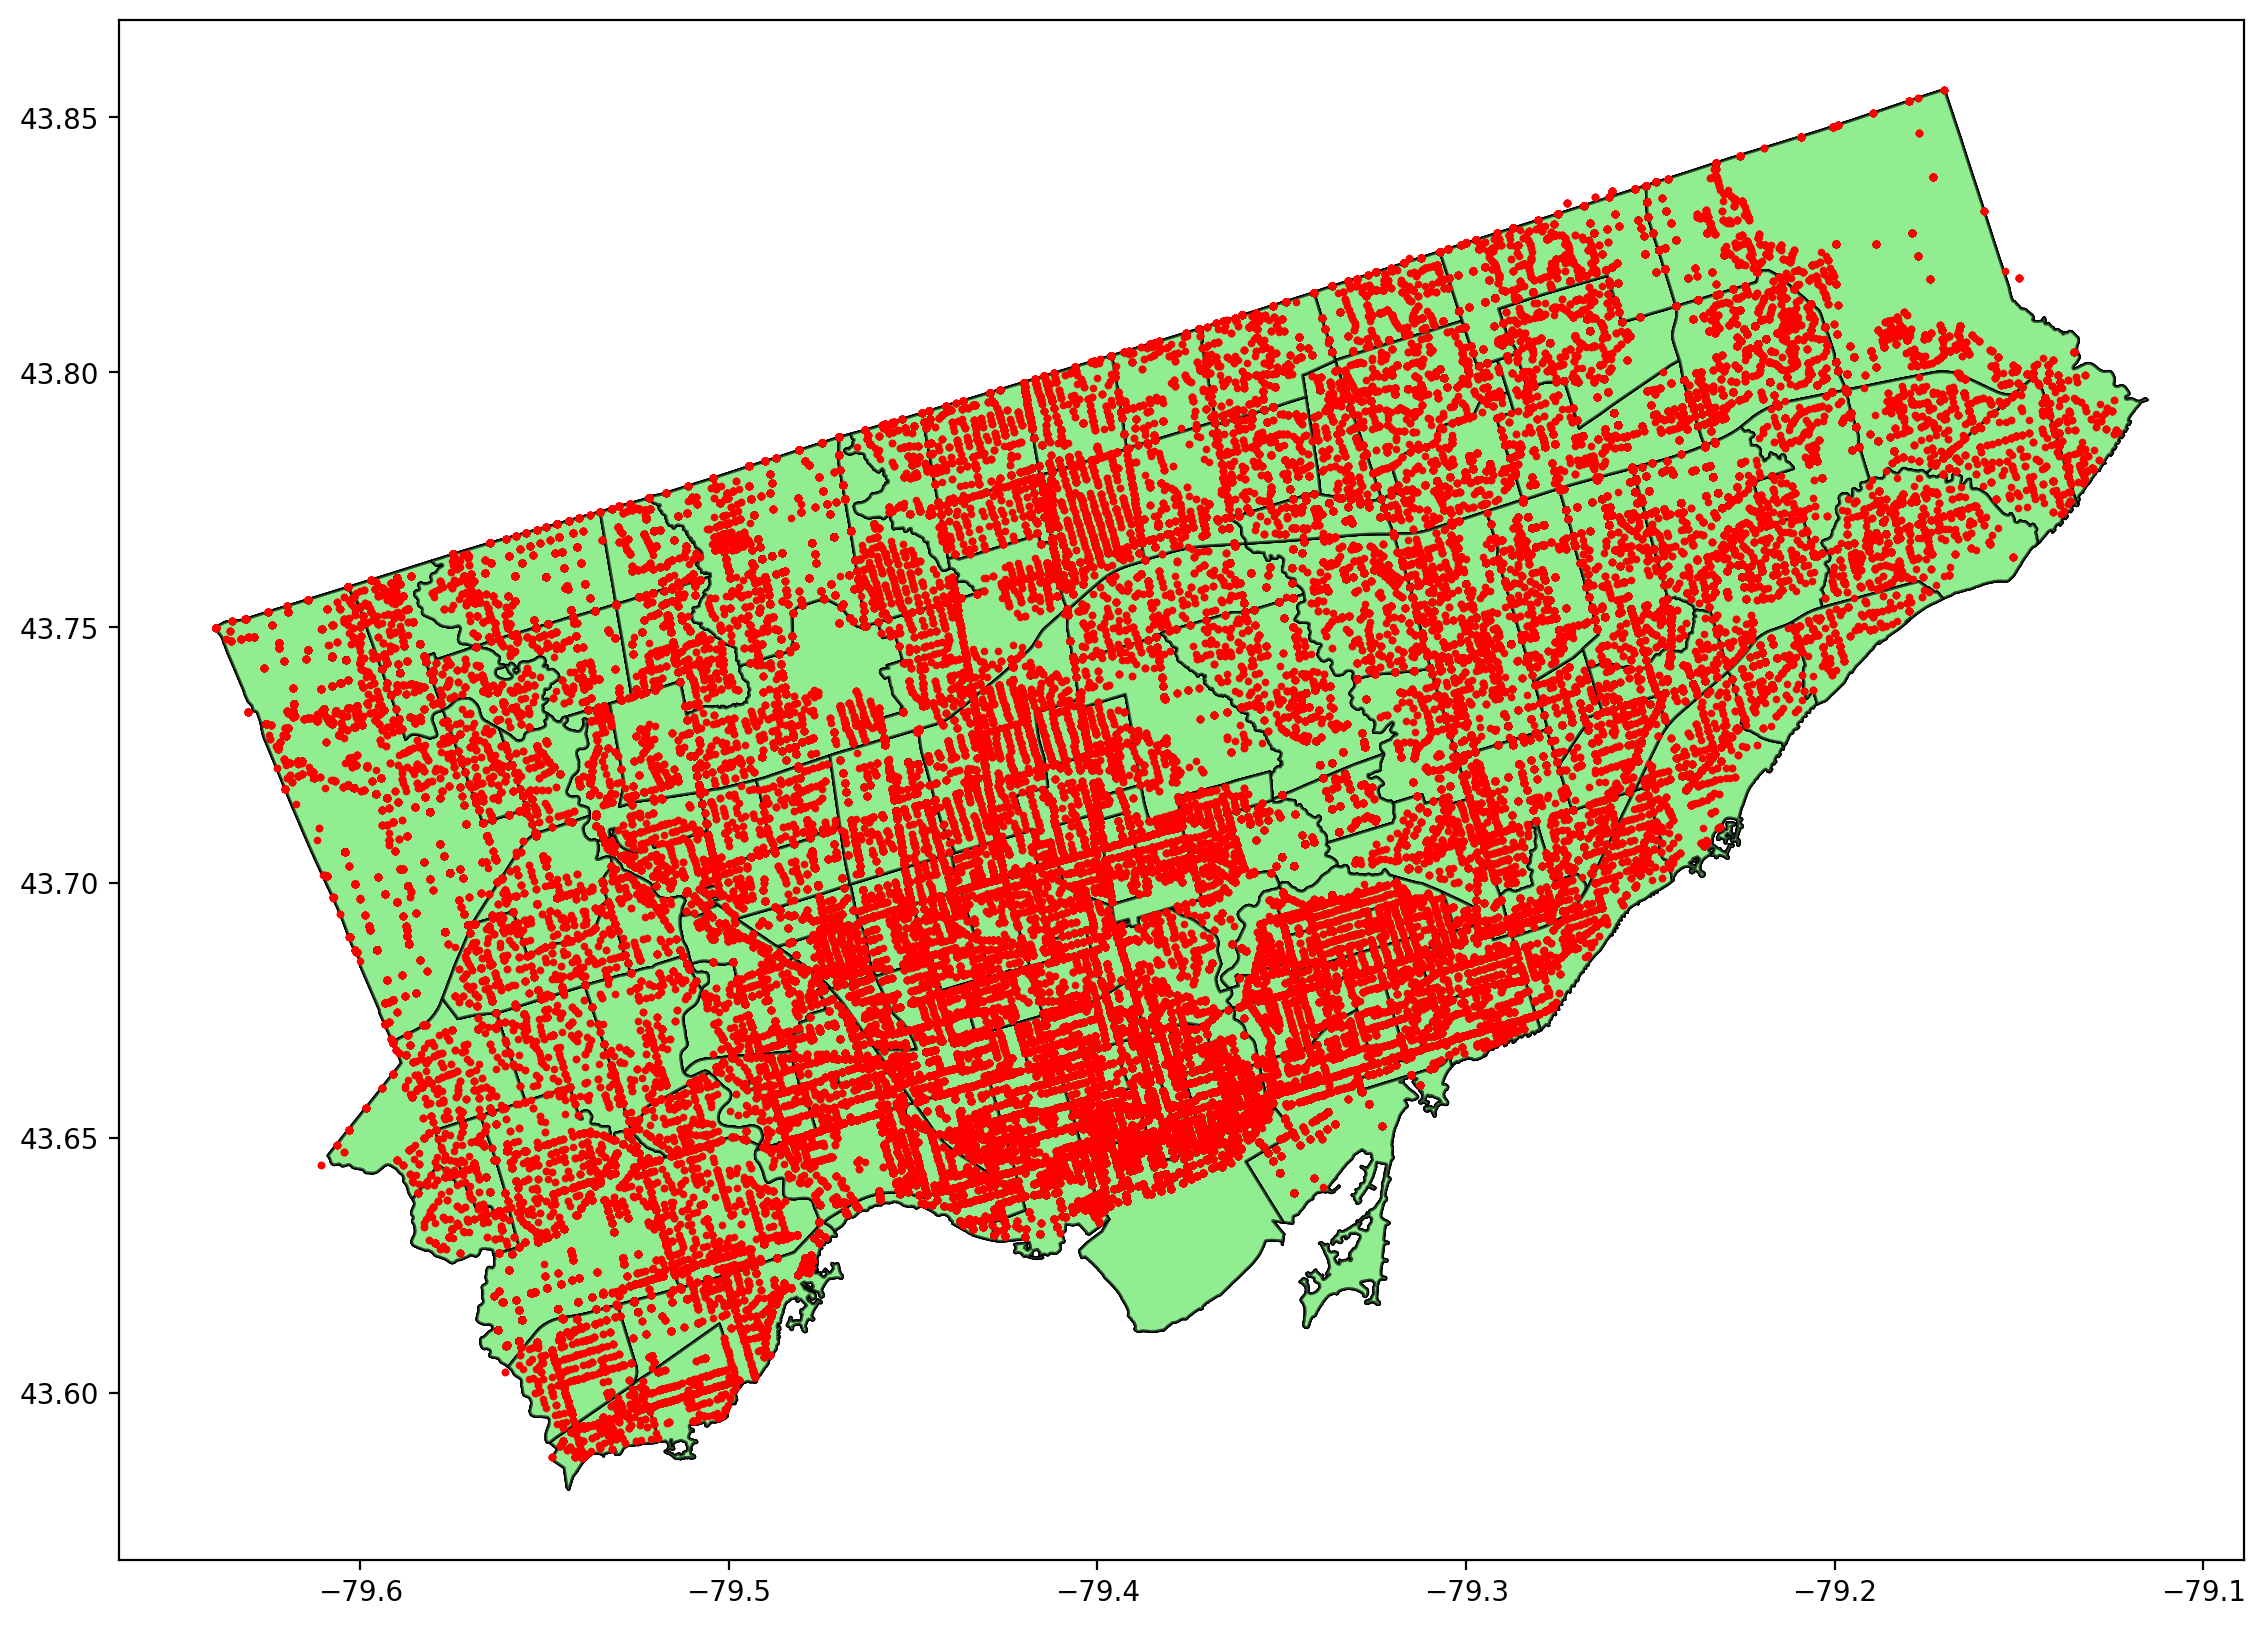

In [131]:
# now all the locations with neighbourhood not as NSA are inside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['neighbourhood'] != 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

# Add Fatal_Collisions

In [132]:
collision_point['fatal_collisions'] = [1 if x != 0 else 0 for x in collision_point['fatalities']]

# Output

In [133]:
collision_point

,occurrence_unique_id,occurrence_date,occurrence_month,occurrence_dayofweek,occurrence_year,occurrence_hour,hood_id,neighbourhood,fatalities,injury_collisions,ftr_collisions,pd_collisions,longitude,latitude,occurrence_day,occurrence_dayofyear,geometry,fatal_collisions
0,GO-20141283080,2014-01-04 22:00:00,January,Saturday,2014,22,58,Old East York,0,0,1,0,-79.336333,43.697612,4,4,POINT (-79.33633 43.69761),0
1,GO-20141384134,2014-01-21 12:00:00,January,Tuesday,2014,12,11,Eringate-Centennial-West Deane,0,0,0,1,-79.561759,43.664797,21,21,POINT (-79.56176 43.66480),0
2,GO-20141283152,2014-01-04 22:00:00,January,Saturday,2014,22,130,Milliken,0,0,1,0,-79.280932,43.828194,4,4,POINT (-79.28093 43.82819),0
3,GO-20141384194,2014-01-21 12:00:00,January,Tuesday,2014,12,27,York University Heights,0,1,0,0,-79.471439,43.767827,21,21,POINT (-79.47144 43.76783),0
4,GO-20141283293,2014-01-04 22:00:00,January,Saturday,2014,22,130,Milliken,0,0,0,1,-79.282497,43.822062,4,4,POINT (-79.28250 43.82206),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452740,GO-202240093,2021-12-15 12:00:00,December,Wednesday,2021,12,26,Downsview-Roding-CFB,0,0,0,1,-79.508595,43.720916,15,349,POINT (-79.50859 43.72092),0
452741,GO-202241692,2021-12-24 01:00:00,December,Friday,2021,1,21,Humber Summit,0,0,0,1,-79.543408,43.770921,24,358,POINT (-79.54341 43.77092),0
452742,GO-20228035384,2021-12-31 16:00:00,December,Friday,2021,16,36,Newtonbrook West,0,1,0,0,-79.420043,43.798000,31,365,POINT (-79.42004 43.79800),0
452743,GO-20228035412,2021-12-30 14:00:00,December,Thursday,2021,14,1,West Humber-Clairville,0,0,0,1,-79.601404,43.730470,30,364,POINT (-79.60140 43.73047),0


In [134]:
collision_point['occurrence_quarter'] = collision_point.occurrence_date.dt.quarter

In [135]:
# output file to clean_data folder
# csv instead of geojson due to size
collision_point.drop(columns=['geometry']).to_csv('../data/processed/collision_select.csv', index=False)

# Aggregate traffic collsions by neighbourhood

<AxesSubplot:xlabel='occurrence_year'>

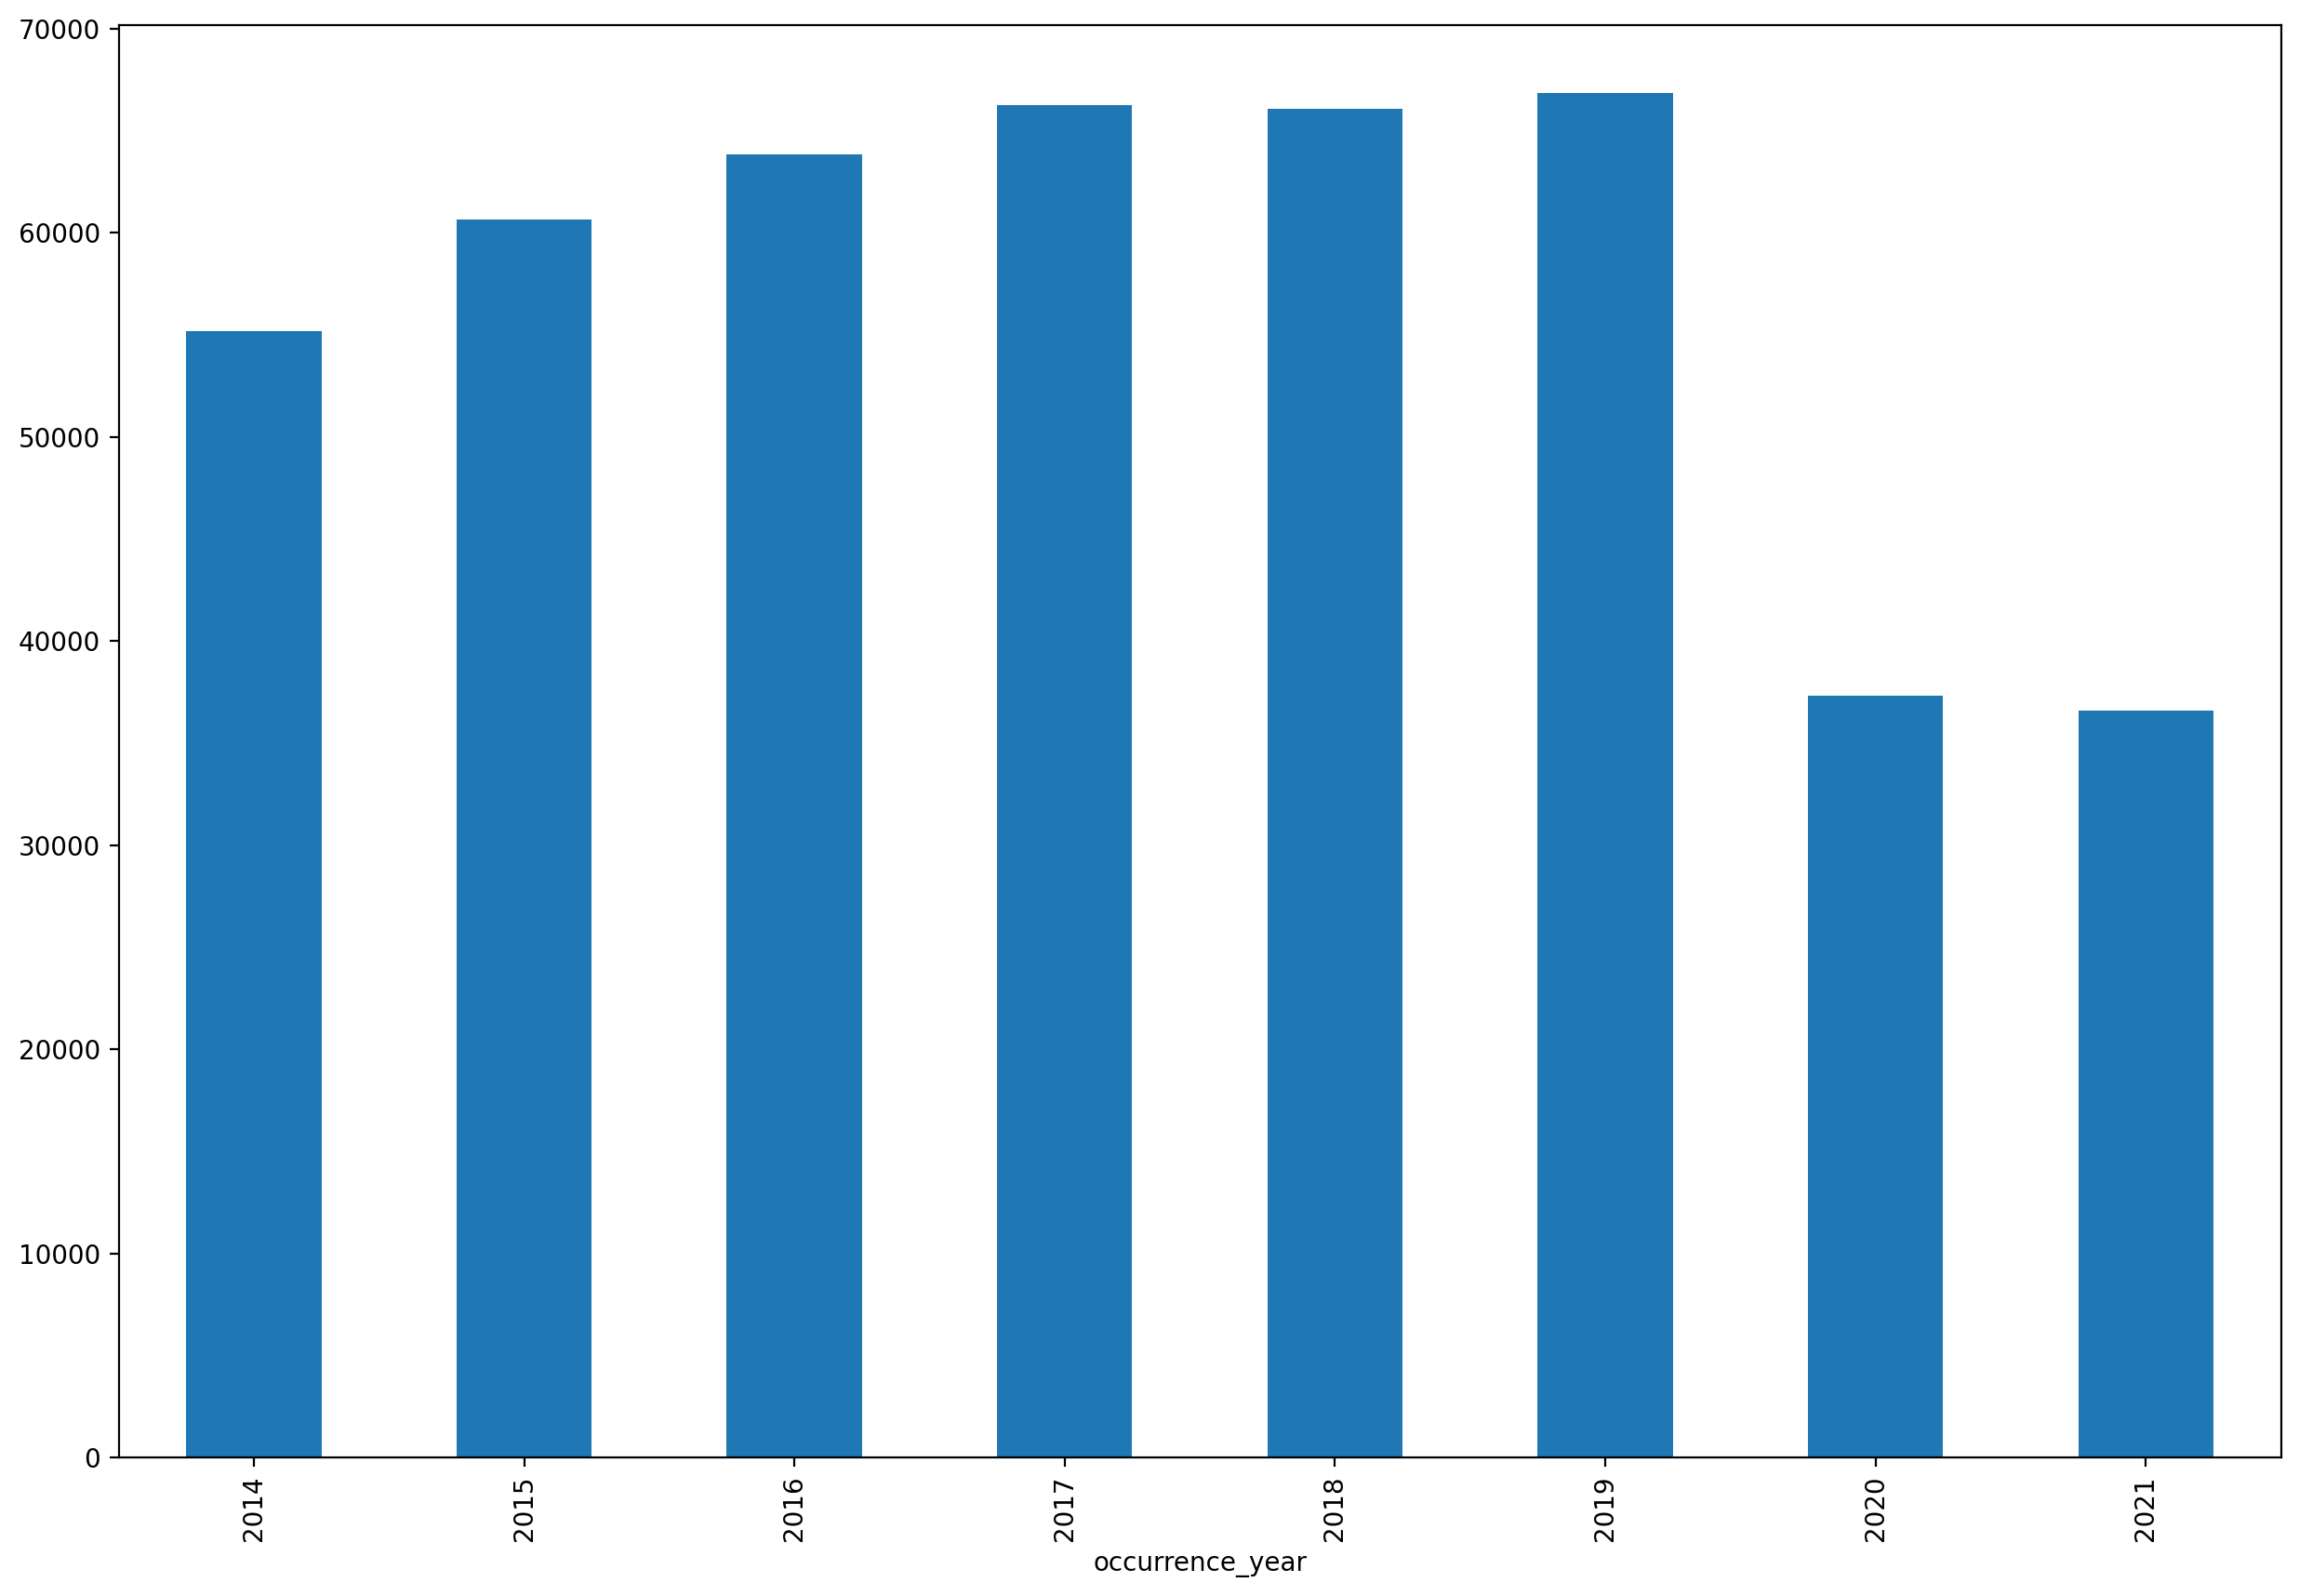

In [136]:
# There is limited data for crimes which happened before 2014
collision_point.groupby("occurrence_year").size().plot(kind="bar")

In [137]:
# filter out data before 2014 and marked as NSA (outside City of Toronto)
collision_groupby = collision_point[collision_point.neighbourhood != "NSA"].\
    groupby(["neighbourhood", "hood_id", "occurrence_year", "occurrence_quarter"]).\
    agg({
        "occurrence_unique_id": "size",
        "fatal_collisions": "sum",
        "injury_collisions": "sum",
        "ftr_collisions": "sum",
        "pd_collisions": "sum"})
    
# unstack to fill those combinations with no record with 0
collision_groupby = collision_groupby.unstack(fill_value=0).stack().reset_index()

collision_groupby.rename(columns={"occurrence_unique_id": "collision"}, inplace=True)
collision_groupby = collision_groupby.melt(id_vars=["neighbourhood", "hood_id", "occurrence_year", "occurrence_quarter"],
                                           var_name="collision_type",
                                           value_name="count")
collision_groupby

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,collision_type,count
0,Agincourt North,129,2014,1,collision,145
1,Agincourt North,129,2014,2,collision,102
2,Agincourt North,129,2014,3,collision,114
3,Agincourt North,129,2014,4,collision,122
4,Agincourt North,129,2015,1,collision,155
...,...,...,...,...,...,...
22395,Yorkdale-Glen Park,31,2020,4,pd_collisions,84
22396,Yorkdale-Glen Park,31,2021,1,pd_collisions,60
22397,Yorkdale-Glen Park,31,2021,2,pd_collisions,75
22398,Yorkdale-Glen Park,31,2021,3,pd_collisions,126


In [138]:
collision_groupby.occurrence_year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

## Add neighbourhood information

In [141]:
neighbourhoods_final = neighbourhoods[['hood_id', 'occurrence_year', 'area', 'population']]
neighbourhoods_final

,hood_id,occurrence_year,area,population
0,1,2014,30.145103,34745
1,1,2015,30.145103,34557
2,1,2016,30.145103,34418
3,1,2017,30.145103,35085
4,1,2018,30.145103,35772
...,...,...,...,...
1255,99,2018,3.088880,17633
1256,99,2019,3.088880,17812
1257,99,2020,3.088880,17972
1258,99,2021,3.088880,18261


In [142]:
collision_groupby

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,collision_type,count
0,Agincourt North,129,2014,1,collision,145
1,Agincourt North,129,2014,2,collision,102
2,Agincourt North,129,2014,3,collision,114
3,Agincourt North,129,2014,4,collision,122
4,Agincourt North,129,2015,1,collision,155
...,...,...,...,...,...,...
22395,Yorkdale-Glen Park,31,2020,4,pd_collisions,84
22396,Yorkdale-Glen Park,31,2021,1,pd_collisions,60
22397,Yorkdale-Glen Park,31,2021,2,pd_collisions,75
22398,Yorkdale-Glen Park,31,2021,3,pd_collisions,126


In [143]:
collision_merge = neighbourhoods_final.merge(collision_groupby, how='inner', on=['hood_id', 'occurrence_year'])
collision_merge

,hood_id,occurrence_year,area,population,neighbourhood,occurrence_quarter,collision_type,count
0,1,2014,30.145103,34745,West Humber-Clairville,1,collision,353
1,1,2014,30.145103,34745,West Humber-Clairville,2,collision,303
2,1,2014,30.145103,34745,West Humber-Clairville,3,collision,322
3,1,2014,30.145103,34745,West Humber-Clairville,4,collision,312
4,1,2014,30.145103,34745,West Humber-Clairville,1,fatal_collisions,0
...,...,...,...,...,...,...,...,...
22395,99,2021,3.088880,18261,Mount Pleasant East,4,ftr_collisions,9
22396,99,2021,3.088880,18261,Mount Pleasant East,1,pd_collisions,48
22397,99,2021,3.088880,18261,Mount Pleasant East,2,pd_collisions,36
22398,99,2021,3.088880,18261,Mount Pleasant East,3,pd_collisions,54


In [144]:
collision_merge.isna().sum()

hood_id               0
occurrence_year       0
area                  0
population            0
neighbourhood         0
occurrence_quarter    0
collision_type        0
count                 0
dtype: int64

## add rate / density

In [145]:
# rate: number of collisions per 100k people
collision_merge['rate'] = collision_merge['count'] / collision_merge['population'] * 10**5
# density: number of collisions per 1km^2
collision_merge['density'] = collision_merge['count'] / collision_merge['area']

In [146]:
collision_merge

,hood_id,occurrence_year,area,population,neighbourhood,occurrence_quarter,collision_type,count,rate,density
0,1,2014,30.145103,34745,West Humber-Clairville,1,collision,353,1015.973521,11.710028
1,1,2014,30.145103,34745,West Humber-Clairville,2,collision,303,872.067923,10.051384
2,1,2014,30.145103,34745,West Humber-Clairville,3,collision,322,926.752051,10.681669
3,1,2014,30.145103,34745,West Humber-Clairville,4,collision,312,897.970931,10.349940
4,1,2014,30.145103,34745,West Humber-Clairville,1,fatal_collisions,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
22395,99,2021,3.088880,18261,Mount Pleasant East,4,ftr_collisions,9,49.285362,2.913678
22396,99,2021,3.088880,18261,Mount Pleasant East,1,pd_collisions,48,262.855265,15.539613
22397,99,2021,3.088880,18261,Mount Pleasant East,2,pd_collisions,36,197.141449,11.654710
22398,99,2021,3.088880,18261,Mount Pleasant East,3,pd_collisions,54,295.712173,17.482065


In [148]:
collision_melt = collision_merge.melt(id_vars=['neighbourhood', 'hood_id', 'occurrence_year', 'occurrence_quarter', 'area', 'population', 'collision_type'],
                                      value_vars=['count', 'rate', 'density'],
                                      var_name='type',
                                      value_name='value')
collision_melt

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,area,population,collision_type,type,value
0,West Humber-Clairville,1,2014,1,30.145103,34745,collision,count,353.000000
1,West Humber-Clairville,1,2014,2,30.145103,34745,collision,count,303.000000
2,West Humber-Clairville,1,2014,3,30.145103,34745,collision,count,322.000000
3,West Humber-Clairville,1,2014,4,30.145103,34745,collision,count,312.000000
4,West Humber-Clairville,1,2014,1,30.145103,34745,fatal_collisions,count,0.000000
...,...,...,...,...,...,...,...,...,...
67195,Mount Pleasant East,99,2021,4,3.088880,18261,ftr_collisions,density,2.913678
67196,Mount Pleasant East,99,2021,1,3.088880,18261,pd_collisions,density,15.539613
67197,Mount Pleasant East,99,2021,2,3.088880,18261,pd_collisions,density,11.654710
67198,Mount Pleasant East,99,2021,3,3.088880,18261,pd_collisions,density,17.482065


In [161]:
collision_melt.to_csv('../data/processed/neighbourhoods_collision.csv', index=False)